In [34]:
import tensorflow as tf
import cv2
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
import random
from collections import deque
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import ConvLSTM2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

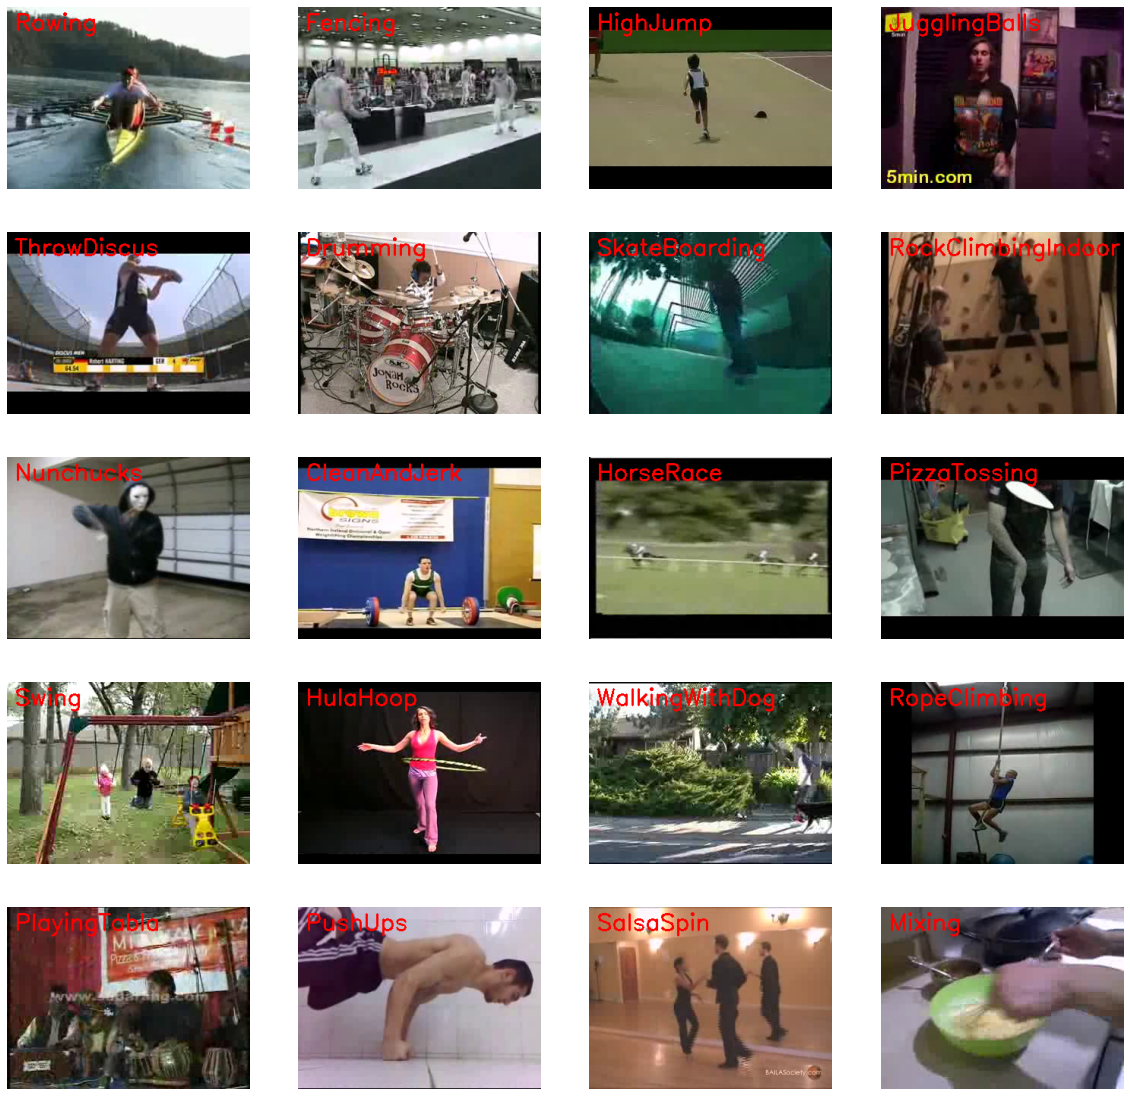

In [2]:
all_class_names = os.listdir("UCF50")
random_array = random.sample(range(len(all_class_names)), 20)
fig = plt.figure(figsize=(20,20))

for c, class_idx in enumerate(random_array):
    dir = "UCF50/{}".format(all_class_names[class_idx])
    video_dir = os.listdir(dir)
    video_path = random.choice(video_dir)
    video = cv2.VideoCapture(dir+"/"+video_path)
    suc, frame = video.read()
    video.release()

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, all_class_names[class_idx], (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    plt.subplot(5,4,c+1)
    plt.imshow(rgb_frame)
    plt.axis('off')
    

In [3]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64,64
SEQUENCE_LENGTH = 20
DATASET_DIR = "UCF50"

CLASS_LIST = ["Punch", "Basketball", "JumpRope"]

In [4]:
def extract_frame(video_path):
    frames = []

    video_reader = cv2.VideoCapture(video_path)
    video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frame_count / SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        suc, frame = video_reader.read()
        if not suc:
            break
        resized_img = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_img / 255
        frames.append(normalized_frame)

    video_reader.release()
    return frames


In [5]:
def create_dataset():
    X = []
    y = []
    video_files_path = []

    for class_index, class_names in enumerate(CLASS_LIST):
        print(f'Extracting frmaes of class: {class_names}')
        video_files = os.listdir(os.path.join(DATASET_DIR, class_names))
        for videos in video_files:
            video_path = os.path.join(DATASET_DIR, class_names, videos)
            frames = extract_frame(video_path)

            if len(frames) == SEQUENCE_LENGTH:
                X.append(frames)
                y.append(class_index)
                video_files_path.append(video_path)
        
    X = np.asarray(X)
    y = np.array(y)

    return X, y, video_files_path


In [6]:
X, y, video_path = create_dataset()

Extracting frmaes of class: Punch
Extracting frmaes of class: Basketball
Extracting frmaes of class: JumpRope


In [7]:
one_hot_encoded_labels = to_categorical(y)
one_hot_encoded_labels.shape

(445, 3)

In [8]:
train_x, test_x, train_y, test_y = train_test_split(X, one_hot_encoded_labels, test_size=0.15, shuffle=True)

In [9]:
def create_model():
    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3,3), activation = 'tanh', data_format = "channels_last", 
                recurrent_dropout = 0.2, return_sequences = True, input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last')) 
    model.add(TimeDistributed(Dropout(0.2)))
    

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3,3), activation = 'tanh', data_format = "channels_last", 
                recurrent_dropout = 0.2, return_sequences = True))
    model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last')) 
    model.add(TimeDistributed(Dropout(0.2)))


    model.add(ConvLSTM2D(filters = 14, kernel_size = (3,3), activation = 'tanh', data_format = "channels_last", 
                recurrent_dropout = 0.2, return_sequences = True))
    model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last')) 
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3,3), activation = 'tanh', data_format = "channels_last", 
                recurrent_dropout = 0.2, return_sequences = True))
    model.add(MaxPooling3D(pool_size = (1,2,2), padding = 'same', data_format = 'channels_last')) 

    model.add(Flatten())
    model.add(Dense(len(CLASS_LIST), activation='softmax'))
    
    model.summary()
    return model
    

In [10]:
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

In [ ]:
plot_model(model, to_file="architecture.png", show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [14]:
early_stoping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [15]:
history = model.fit(x=train_x, y=train_y, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stoping_callback])

Epoch 1/50
76/76 [==============================] - 59s 592ms/step - loss: 1.0137 - accuracy: 0.4603 - val_loss: 0.7737 - val_accuracy: 0.6316
Epoch 2/50
76/76 [==============================] - 45s 597ms/step - loss: 0.6897 - accuracy: 0.7152 - val_loss: 0.4947 - val_accuracy: 0.8158
Epoch 3/50
76/76 [==============================] - 47s 615ms/step - loss: 0.4817 - accuracy: 0.8079 - val_loss: 0.4351 - val_accuracy: 0.8289
Epoch 4/50
76/76 [==============================] - 46s 601ms/step - loss: 0.3695 - accuracy: 0.8808 - val_loss: 0.3246 - val_accuracy: 0.8947
Epoch 5/50
76/76 [==============================] - 44s 578ms/step - loss: 0.2602 - accuracy: 0.9106 - val_loss: 0.3424 - val_accuracy: 0.8816
Epoch 6/50
76/76 [==============================] - 43s 567ms/step - loss: 0.2257 - accuracy: 0.9272 - val_loss: 0.2428 - val_accuracy: 0.9211
Epoch 7/50
76/76 [==============================] - 45s 599ms/step - loss: 0.1426 - accuracy: 0.9503 - val_loss: 0.2478 - val_accuracy: 0.9079

In [27]:
evaluation_histor = model.evaluate(test_x, test_y)
evaluation_histor

3/3 [==============================] - 1s 192ms/step - loss: 0.2555 - accuracy: 0.9403


[0.25547996163368225, 0.9402984976768494]

In [37]:
def preditct_on_video(video_path, out_file_path):
    video_reader = cv2.VideoCapture(video_path)
    suc, frame = video_reader.read()
    org_height, org_width, channel = frame.shape

    video_writer = cv2.VideoWriter(out_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                        video_reader.get(cv2.CAP_PROP_FPS),(org_width, org_height)) 

    frames_queue = deque(maxlen=SEQUENCE_LENGTH)

    while video_reader.isOpened():
        suc, frame = video_reader.read()
        if not suc:
            break
        
        resi_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        norm_img = resi_frame / 255
        frames_queue.append(norm_img)
        pred_class = ""
        if len(frames_queue) == SEQUENCE_LENGTH:
            predict = model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predict = np.argmax(predict)
            pred_class = CLASS_LIST[predict]

        cv2.putText(frame, pred_class, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
        video_writer.write(frame)

    video_reader.release()
    video_writer.release()


In [40]:
preditct_on_video(r"D:\Activity recognition\test_vid\3.mkv", r"D:\Activity recognition\output.mp4")

AttributeError: 'NoneType' object has no attribute 'shape'

In [30]:
model_loss, model_accuracy = evaluation_histor

data_time_format = '%Y_%m_%d__%H_%M_%S'
current_data_time = dt.datetime.now()
current_data_time = dt.datetime.strftime(current_data_time, data_time_format)

model_file_name = f'convLstm_model_{current_data_time}__loss_{model_loss}__accuracy_{model_accuracy}.h5'
model.save(model_file_name)

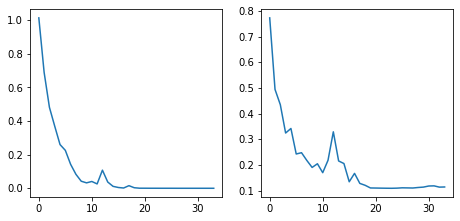

In [26]:
epochs = history.epoch
loss = history.history['loss']

plt.figure(figsize=(20,20))
plt.subplot(5,5, 1)
plt.plot(epochs, loss)

val_loss = history.history['val_loss']
plt.subplot(5,5, 2)
plt.plot(epochs, val_loss)


In [31]:
video_reader = cv2.VideoCapture(r"D:\Activity recognition\UCF50\Punch\v_Punch_g01_c04.avi")
video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
skip_frames_window = max(int(video_frame_count / SEQUENCE_LENGTH), 1)

In [33]:
suc, v = video_reader.read()
v.shape

(240, 320, 3)